# Import Python libraries and set environment variables:

In [2]:
import os, json, math, shutil
import numpy as np
import tensorflow as tf
!sudo apt install graphviz -y

# environment variables used by bash cells
PROJECT=!(gcloud config get-value project)
PROJECT=PROJECT[0]

REGION = 'us-east1'
BUCKET='{}-dsongcp'.format(PROJECT)
os.environ['ENDPOINT_NAME'] = 'flights'

os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TF_VERSION']='2-' + tf.__version__[2:4]

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-5).
0 upgraded, 0 newly installed, 0 to remove and 2 not upgraded.


Create training dataset flights_train_data for model training:

In [3]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_train_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'True'

Query is running:   0%|          |

""


## Create the evaluation dataset flights_eval_data for model evaluation:

In [4]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_eval_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False AND
  is_train_day = 'False'

Query is running:   0%|          |

""


## Create the full dataset flights_all_data using the following code:

In [5]:
%%bigquery
CREATE OR REPLACE TABLE dsongcp.flights_all_data AS

SELECT
  IF(arr_delay < 15, 1.0, 0.0) AS ontime,
  dep_delay,
  taxi_out,
  distance,
  origin,
  dest,
  EXTRACT(hour FROM dep_time) AS dep_hour,
  IF (EXTRACT(dayofweek FROM dep_time) BETWEEN 2 AND 6, 1, 0) AS is_weekday,
  UNIQUE_CARRIER AS carrier,
  dep_airport_lat,
  dep_airport_lon,
  arr_airport_lat,
  arr_airport_lon,
  IF (is_train_day = 'True',
      IF(ABS(MOD(FARM_FINGERPRINT(CAST(f.FL_DATE AS STRING)), 100)) < 60, 'TRAIN', 'VALIDATE'),
      'TEST') AS data_split
FROM dsongcp.flights_tzcorr f
JOIN dsongcp.trainday t
ON f.FL_DATE = t.FL_DATE
WHERE
  f.CANCELLED = False AND
  f.DIVERTED = False

Query is running:   0%|          |

""


## Export the training, validation, and full datasets to CSV file format the Google Cloud Storage bucket:

Wait until you receive output from running the following bash script in your notebook cell:

In [6]:
%%bash
PROJECT=$(gcloud config get-value project)
for dataset in "train" "eval" "all"; do
  TABLE=dsongcp.flights_${dataset}_data
  CSV=gs://${BUCKET}/ch9/data/${dataset}.csv
  echo "Exporting ${TABLE} to ${CSV} and deleting table"
  bq --project_id=${PROJECT} extract --destination_format=CSV $TABLE $CSV
  bq --project_id=${PROJECT} rm -f $TABLE
done

Exporting dsongcp.flights_train_data to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/train.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r47cff04eccaeab1e_0000018eee70cc97_1 ... (66s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Exporting dsongcp.flights_eval_data to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/eval.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r79570f2cf4883bde_0000018eee71ded2_1 ... (23s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


Exporting dsongcp.flights_all_data to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/all.csv and deleting table


/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
Waiting on bqjob_r486e85b8dfc8fbfa_0000018eee724c54_1 ... (109s) Current status: DONE   
/usr/lib/google-cloud-sdk/platform/bq/third_party/requests/__init__.py:103: RequestsDependencyWarning: urllib3 (2.0.7) or chardet (None)/charset_normalizer (2.0.7) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [7]:
!gsutil ls -lh gs://{BUCKET}/ch9/data

445.01 MiB  2024-04-17T23:45:42Z  gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/all.csv
115.19 MiB  2024-04-17T23:44:01Z  gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/eval.csv
296.96 MiB  2024-04-17T23:43:37Z  gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/data/train.csv
TOTAL: 3 objects, 898801258 bytes (857.16 MiB)


## Create Input Data

For development purposes, train for a few epochs. That's why the NUM_EXAMPLES is so low.

In [8]:
DEVELOP_MODE = True
NUM_EXAMPLES = 5000*1000

Assign your training and validation data URI to training_data_uri and validation_data_uri respectively:

In [9]:
training_data_uri = 'gs://{}/ch9/data/train*'.format(BUCKET)
validation_data_uri = 'gs://{}/ch9/data/eval*'.format(BUCKET)

Set up Model Parameters using the following code-block:

In [10]:
NBUCKETS = 5
NEMBEDS = 3
TRAIN_BATCH_SIZE = 64
DNN_HIDDEN_UNITS = '64,32'

Reading data into TensorFlow
To read the CSV files from Google Cloud Storage into TensorFlow, use a method from the tf.data package:

In [11]:
if DEVELOP_MODE:
    train_df = tf.data.experimental.make_csv_dataset(training_data_uri, batch_size=5)
    for n, data in enumerate(train_df):
        numpy_data = {k: v.numpy() for k, v in data.items()}
        print(n, numpy_data)
        if n==1: break

2024-04-17 23:50:10.100833: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-17 23:50:10.100902: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-04-17 23:50:10.100938: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lab-apr-17-2024): /proc/driver/nvidia/version does not exist
2024-04-17 23:50:10.105346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the 

0 {'ontime': array([0, 1, 1, 0, 1], dtype=int32), 'dep_delay': array([61, -5,  2, 22, -3], dtype=int32), 'taxi_out': array([19, 11,  5, 30, 24], dtype=int32), 'distance': array([ 129, 2446, 1843,  852, 2603], dtype=int32), 'origin': array([b'SEA', b'MCO', b'HOU', b'DEN', b'HNL'], dtype=object), 'dest': array([b'PDX', b'SFO', b'PDX', b'PSC', b'PDX'], dtype=object), 'dep_hour': array([ 2, 23, 18,  4, 22], dtype=int32), 'is_weekday': array([1, 1, 1, 1, 1], dtype=int32), 'carrier': array([b'OO', b'UA', b'WN', b'OO', b'AS'], dtype=object), 'dep_airport_lat': array([47.45    , 28.429445, 29.645555, 39.861668, 21.317778],
      dtype=float32), 'dep_airport_lon': array([-122.31167,  -81.30889,  -95.27889, -104.67306, -157.92027],
      dtype=float32), 'arr_airport_lat': array([45.58861, 37.61889, 45.58861, 46.26472, 45.58861], dtype=float32), 'arr_airport_lon': array([-122.59695, -122.375  , -122.59695, -119.11916, -122.59695],
      dtype=float32)}
1 {'ontime': array([1, 1, 1, 0, 1], dtype=in

Write features_and_labels() and read_dataset() functions. The read_dataset() function reads the training data, yielding batch_size examples each time, and allows you to stop iterating once a certain number of examples have been read.

The dataset contains all the columns in the CSV file, named according to the header line. The data consists of both features and the label. It’s better to separate them by writing the features_and_labels() function to make the later code easier to read. Hence, we’ll apply a pop() function to the dictionary and return a tuple of features and labels).



Enter and run the following code:

In [12]:
def features_and_labels(features):
  label = features.pop('ontime')
  return features, label

def read_dataset(pattern, batch_size, mode=tf.estimator.ModeKeys.TRAIN, truncate=None):
  dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size, num_epochs=1)
  dataset = dataset.map(features_and_labels)
  if mode == tf.estimator.ModeKeys.TRAIN:
    dataset = dataset.shuffle(batch_size*10)
    dataset = dataset.repeat()
  dataset = dataset.prefetch(1)
  if truncate is not None:
    dataset = dataset.take(truncate)
  return dataset


if DEVELOP_MODE:
    print("Checking input pipeline")
    one_item = read_dataset(training_data_uri, batch_size=2, truncate=1)
    print(list(one_item)) # should print one batch of 2 items

Checking input pipeline
[(OrderedDict([('dep_delay', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([-9,  8], dtype=int32)>), ('taxi_out', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([14, 58], dtype=int32)>), ('distance', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([763, 414], dtype=int32)>), ('origin', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'LAS', b'LAS'], dtype=object)>), ('dest', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'PDX', b'SFO'], dtype=object)>), ('dep_hour', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([16, 18], dtype=int32)>), ('is_weekday', <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>), ('carrier', <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'AS', b'UA'], dtype=object)>), ('dep_airport_lat', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([36.08, 36.08], dtype=float32)>), ('dep_airport_lon', <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-115.15222, -115.15222], dtype=float32)>), ('arr_airport

## Create, Train and evaluate TensorFlow Model

In [13]:
import tensorflow as tf

real = {
    colname : tf.feature_column.numeric_column(colname)
          for colname in
            (
                'dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
                'dep_airport_lat,dep_airport_lon,' +
                'arr_airport_lat,arr_airport_lon'
            ).split(',')
}
sparse = {
      'carrier': tf.feature_column.categorical_column_with_vocabulary_list('carrier',
                  vocabulary_list='AS,VX,F9,UA,US,WN,HA,EV,MQ,DL,OO,B6,NK,AA'.split(',')),
      'origin' : tf.feature_column.categorical_column_with_hash_bucket('origin', hash_bucket_size=1000),
      'dest'   : tf.feature_column.categorical_column_with_hash_bucket('dest', hash_bucket_size=1000),
}

All these features come directly from the input file (and are provided by any client that wants a prediction for a flight). Input layers map 1:1 to the input features and their types, so rather than repeat the column names, you create an input layer for each of these columns, specifying the right data type (either a float or a string).

Enter and run the following code:

In [14]:
inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
          for colname in sparse.keys()
})

Real-valued columns whose precision is overkill (thus, likely to cause overfitting) can be discretized and made into categorical columns. For example, if you have a column for the age of the aircraft, you might discretize into just three bins—less than 5 years old, 5 to 20 years old, and more than 20 years old. Use the discretization shortcut: you can discretize the latitudes and longitudes and cross the buckets—this results in breaking up the country into grids and yield the grid point into which a specific latitude and longitude falls.

Enter and run the following code:


In [15]:
latbuckets = np.linspace(20.0, 50.0, NBUCKETS).tolist()  # USA
lonbuckets = np.linspace(-120.0, -70.0, NBUCKETS).tolist() # USA
disc = {}
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], latbuckets)
          for key in ['dep_airport_lat', 'arr_airport_lat']
})
disc.update({
       'd_{}'.format(key) : tf.feature_column.bucketized_column(real[key], lonbuckets)
          for key in ['dep_airport_lon', 'arr_airport_lon']
})

# cross columns that make sense in combination
sparse['dep_loc'] = tf.feature_column.crossed_column(
    [disc['d_dep_airport_lat'], disc['d_dep_airport_lon']], NBUCKETS*NBUCKETS)
sparse['arr_loc'] = tf.feature_column.crossed_column(
    [disc['d_arr_airport_lat'], disc['d_arr_airport_lon']], NBUCKETS*NBUCKETS)
sparse['dep_arr'] = tf.feature_column.crossed_column([sparse['dep_loc'], sparse['arr_loc']], NBUCKETS ** 4)

# embed all the sparse columns
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, NEMBEDS)
          for colname, col in sparse.items()
}
real.update(embed)

# one-hot encode the sparse columns
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

if DEVELOP_MODE:
    print(sparse.keys())
    print(real.keys())

dict_keys(['carrier', 'origin', 'dest', 'dep_loc', 'arr_loc', 'dep_arr'])
dict_keys(['dep_delay', 'taxi_out', 'distance', 'dep_hour', 'is_weekday', 'dep_airport_lat', 'dep_airport_lon', 'arr_airport_lat', 'arr_airport_lon', 'embed_carrier', 'embed_origin', 'embed_dest', 'embed_dep_loc', 'embed_arr_loc', 'embed_dep_arr'])


## Train and Evaluate Model

Save the checkpoint:

In [17]:
output_dir='gs://{}/ch9/trained_model'.format(BUCKET)
os.environ['OUTDIR'] = output_dir  # needed for deployment
print('Writing trained model to {}'.format(output_dir))

Writing trained model to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model


Delete the model checkpoints already present in the storage bucket:

In [18]:
!gsutil -m rm -rf $OUTDIR

CommandException: 1 files/objects could not be removed.


This reports an error stating CommandException: 1 files/objects could not be removed because the model has not yet been saved. The error indicates that there are no files present in the target location. You must be certain that this location is empty before attempting to save the model and this command guarantees that.

With the sparse and real feature columns thus enhanced beyond the raw inputs, you can create a wide_and_deep_classifier passing in the linear and deep feature columns separately:

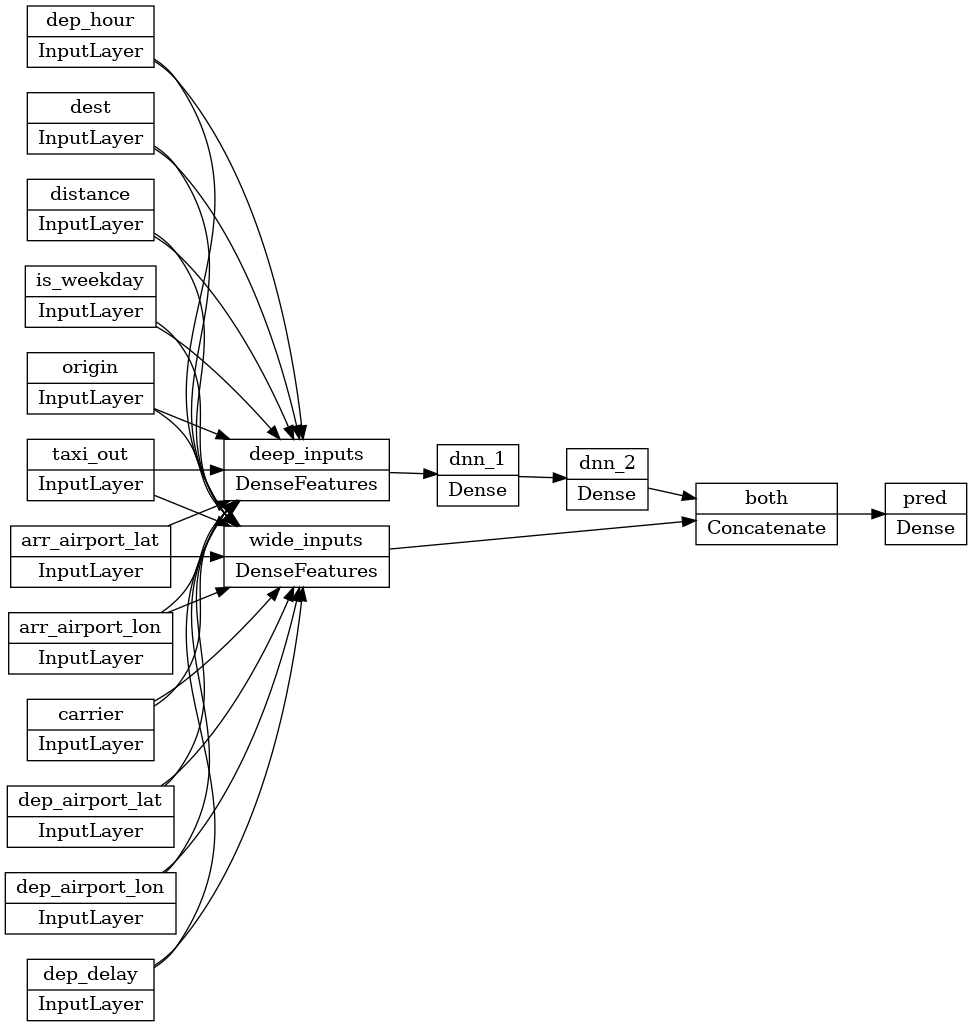

In [19]:
# Build a wide-and-deep model.
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'flights_model.png', show_shapes=False, rankdir='LR')

Use train_dataset for model training and eval_dataset for model evaluation.

Create the model using the following code-blocks:


In [20]:
# training and evaluation dataset
train_batch_size = TRAIN_BATCH_SIZE
if DEVELOP_MODE:
    eval_batch_size = 100
    steps_per_epoch = 3
    epochs = 2
    num_eval_examples = eval_batch_size*10
else:
    eval_batch_size = 100
    steps_per_epoch = NUM_EXAMPLES // train_batch_size
    epochs = 10
    num_eval_examples = eval_batch_size * 100
train_dataset = read_dataset(training_data_uri, train_batch_size)
eval_dataset = read_dataset(validation_data_uri, eval_batch_size, tf.estimator.ModeKeys.EVAL, num_eval_examples)

checkpoint_path = '{}/checkpoints/flights.cpt'.format(output_dir)
shutil.rmtree(checkpoint_path, ignore_errors=True)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(train_dataset,
                    validation_data=eval_dataset,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    callbacks=[cp_callback])

Epoch 1/2
1/3 [=========>....................] - ETA: 13s - loss: 0.9690 - accuracy: 0.7344
Epoch 1: saving model to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 18s 6s/step - loss: 0.8669 - accuracy: 0.5417 - val_loss: 0.5701 - val_accuracy: 0.8159
Epoch 2/2
1/3 [=========>....................] - ETA: 0s - loss: 0.4849 - accuracy: 0.8125
Epoch 2: saving model to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/checkpoints/flights.cpt
3/3 [==============================] - 12s 6s/step - loss: 0.7451 - accuracy: 0.8490 - val_loss: 0.6990 - val_accuracy: 0.8430


Visualize the model loss and model accuracy using matplotlib.pyplot:

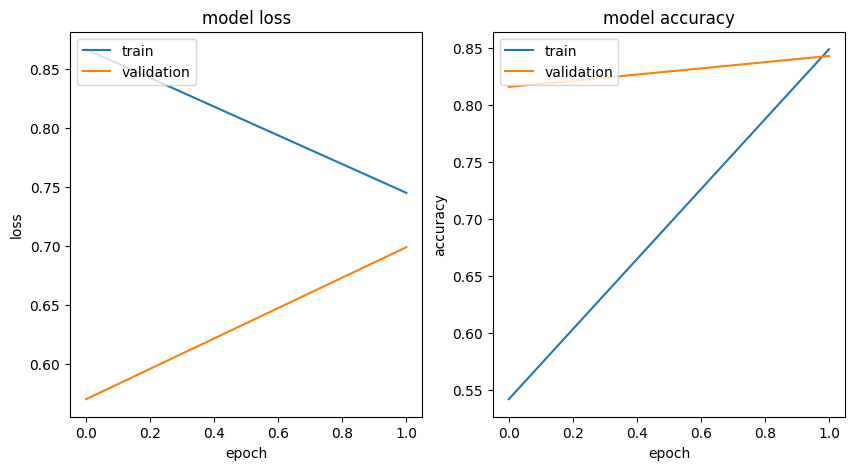

In [21]:
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'accuracy']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

Export the trained model

Save the model artifacts to the Google Cloud Storage bucket:


In [22]:
import time
export_dir = '{}/export/flights_{}'.format(output_dir, time.strftime("%Y%m%d-%H%M%S"))
print('Exporting to {}'.format(export_dir))
tf.saved_model.save(model, export_dir)

Exporting to gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746/assets


INFO:tensorflow:Assets written to: gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746/assets


# Deploy flights model to Vertex AI

In [23]:
%%bash
# note TF_VERSION and ENDPOINT_NAME set in 1st cell
# TF_VERSION=2-6
# ENDPOINT_NAME=flights

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# create the model using the parameters docker conatiner image and artifact uri
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746/


Using endpoint [https://us-east1-aiplatform.googleapis.com/]


Creating Endpoint for flights-20240417-235851


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [3008977121763655680]...
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Created Vertex AI endpoint: projects/306910072390/locations/us-east1/endpoints/6044116572954427392.
Using endpoint [https://us-east1-aip

ENDPOINT_ID=6044116572954427392


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [7429823105981218816]...
.............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................done.
Using endpoint [https://us-east1-aiplatform.googleapis.com/]


MODEL_ID=7150968540357459968


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [1665215582946983936]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Note: It will take around 15-20 minutes to create the model, model endpoint, and deploy the model to the endpoint. If you are unable to access the generated endpoint link, please ignore it. To see the progress in your Cloud Console, click on Navigation menu > Vertex AI > Online prediction > Endpoints.

Create a test input file example_input.json using the following code:


In [24]:
%%writefile example_input.json
{"instances": [
  {"dep_hour": 2, "is_weekday": 1, "dep_delay": 40, "taxi_out": 17, "distance": 41, "carrier": "AS", "dep_airport_lat": 58.42527778, "dep_airport_lon": -135.7075, "arr_airport_lat": 58.35472222, "arr_airport_lon": -134.57472222, "origin": "GST", "dest": "JNU"},
  {"dep_hour": 22, "is_weekday": 0, "dep_delay": -7, "taxi_out": 7, "distance": 201, "carrier": "HA", "dep_airport_lat": 21.97611111, "dep_airport_lon": -159.33888889, "arr_airport_lat": 20.89861111, "arr_airport_lon": -156.43055556, "origin": "LIH", "dest": "OGG"}
]}

Writing example_input.json


Make a prediction from the model endpoint. Here you have input data in a JSON file called example_input.json:

In [25]:
%%bash
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo $ENDPOINT_ID
gcloud ai endpoints predict $ENDPOINT_ID --region=$REGION --json-request=example_input.json

Using endpoint [https://us-east1-aiplatform.googleapis.com/]


6044116572954427392


Using endpoint [https://us-east1-prediction-aiplatform.googleapis.com/]


[[0.913408577], [0.787132502]]


Here’s how client programs can invoke the model that you deployed.

Assume that they have the input data in a JSON file called example_input.json.

Now, send an HTTP POST request and you will get the result back as JSON:

In [26]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:predict"

Using endpoint [https://us-east1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   831    0   288  100   543   4430   8353 --:--:-- --:--:-- --:--:-- 12784


{
  "predictions": [
    [
      0.913408577
    ],
    [
      0.787132502
    ]
  ],
  "deployedModelId": "5641572171886100480",
  "model": "projects/306910072390/locations/us-east1/models/7150968540357459968",
  "modelDisplayName": "flights-20240417-235851",
  "modelVersionId": "1"
}


# Model Explainability

Model explainability is one of the most important problems in machine learning. It's a broad concept of analyzing and understanding the results provided by machine learning models. Explainability in machine learning means you can explain what happens in your model from input to output. It makes models transparent and solves the black box problem. Explainable AI (XAI) is the more formal way to describe this.

Run the following code:

In [27]:
%%bash
model_dir=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $model_dir
saved_model_cli show --tag_set serve --signature_def serving_default --dir $model_dir

gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746/


2024-04-18 00:19:30.494826: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 00:19:31.906162: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2024-04-18 00:19:31.906295: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/loca

The given SavedModel SignatureDef contains the following input(s):
  inputs['arr_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lat:0
  inputs['arr_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_arr_airport_lon:0
  inputs['carrier'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_carrier:0
  inputs['dep_airport_lat'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lat:0
  inputs['dep_airport_lon'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_airport_lon:0
  inputs['dep_delay'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_delay:0
  inputs['dep_hour'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: serving_default_dep_hour:0
  inputs['dest'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: se

Create a JSON file explanation-metadata.json that contains the metadata describing the Model's input and output for explanation. Here, you use sampled-shapley method used for explanation:


In [28]:
cols = ('dep_delay,taxi_out,distance,dep_hour,is_weekday,' +
        'dep_airport_lat,dep_airport_lon,' +
        'arr_airport_lat,arr_airport_lon,' +
        'carrier,origin,dest')
inputs = {x: {"inputTensorName": "{}".format(x)}
        for x in cols.split(',')}
expl = {
    "inputs": inputs,
    "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}
print(expl)
with open('explanation-metadata.json', 'w') as ofp:
    json.dump(expl, ofp, indent=2)

{'inputs': {'dep_delay': {'inputTensorName': 'dep_delay'}, 'taxi_out': {'inputTensorName': 'taxi_out'}, 'distance': {'inputTensorName': 'distance'}, 'dep_hour': {'inputTensorName': 'dep_hour'}, 'is_weekday': {'inputTensorName': 'is_weekday'}, 'dep_airport_lat': {'inputTensorName': 'dep_airport_lat'}, 'dep_airport_lon': {'inputTensorName': 'dep_airport_lon'}, 'arr_airport_lat': {'inputTensorName': 'arr_airport_lat'}, 'arr_airport_lon': {'inputTensorName': 'arr_airport_lon'}, 'carrier': {'inputTensorName': 'carrier'}, 'origin': {'inputTensorName': 'origin'}, 'dest': {'inputTensorName': 'dest'}}, 'outputs': {'pred': {'outputTensorName': 'pred'}}}


View the explanation-metadata.json file using the cat command:

In [29]:
!cat explanation-metadata.json

{
  "inputs": {
    "dep_delay": {
      "inputTensorName": "dep_delay"
    },
    "taxi_out": {
      "inputTensorName": "taxi_out"
    },
    "distance": {
      "inputTensorName": "distance"
    },
    "dep_hour": {
      "inputTensorName": "dep_hour"
    },
    "is_weekday": {
      "inputTensorName": "is_weekday"
    },
    "dep_airport_lat": {
      "inputTensorName": "dep_airport_lat"
    },
    "dep_airport_lon": {
      "inputTensorName": "dep_airport_lon"
    },
    "arr_airport_lat": {
      "inputTensorName": "arr_airport_lat"
    },
    "arr_airport_lon": {
      "inputTensorName": "arr_airport_lon"
    },
    "carrier": {
      "inputTensorName": "carrier"
    },
    "origin": {
      "inputTensorName": "origin"
    },
    "dest": {
      "inputTensorName": "dest"
    }
  },
  "outputs": {
    "pred": {
      "outputTensorName": "pred"
    }
  }
}

Create and deploy another model flights_xai to Vertex AI
Create the model endpoint flights_xai, upload the model, and deploy it at the model endpoint using the following code:

In [30]:
%%bash
# note ENDPOINT_NAME is being changed

ENDPOINT_NAME=flights_xai

TIMESTAMP=$(date +%Y%m%d-%H%M%S)
MODEL_NAME=${ENDPOINT_NAME}-${TIMESTAMP}
EXPORT_PATH=$(gsutil ls ${OUTDIR}/export | tail -1)
echo $EXPORT_PATH

# create the model endpoint for deploying the model
if [[ $(gcloud ai endpoints list --region=$REGION \
        --format='value(DISPLAY_NAME)' --filter=display_name=${ENDPOINT_NAME}) ]]; then
    echo "Endpoint for $MODEL_NAME already exists"
else
    # create model endpoint
    echo "Creating Endpoint for $MODEL_NAME"
    gcloud ai endpoints create --region=${REGION} --display-name=${ENDPOINT_NAME}
fi

ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})
echo "ENDPOINT_ID=$ENDPOINT_ID"


# delete any existing models with this name
for MODEL_ID in $(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME}); do
    echo "Deleting existing $MODEL_NAME ... $MODEL_ID "
    gcloud ai models delete --region=$REGION $MODEL_ID
done


# upload the model using the parameters docker conatiner image, artifact URI, explanation method,
# explanation path count and explanation metadata JSON file `explanation-metadata.json`.
# Here, you keep number of feature permutations to `10` when approximating the Shapley values for explanation.
gcloud ai models upload --region=$REGION --display-name=$MODEL_NAME \
     --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.${TF_VERSION}:latest \
     --artifact-uri=$EXPORT_PATH \
     --explanation-method=sampled-shapley --explanation-path-count=10 --explanation-metadata-file=explanation-metadata.json
MODEL_ID=$(gcloud ai models list --region=$REGION --format='value(MODEL_ID)' --filter=display_name=${MODEL_NAME})
echo "MODEL_ID=$MODEL_ID"


# deploy the model to the endpoint
gcloud ai endpoints deploy-model $ENDPOINT_ID \
  --region=$REGION \
  --model=$MODEL_ID \
  --display-name=$MODEL_NAME \
  --machine-type=e2-standard-2 \
  --min-replica-count=1 \
  --max-replica-count=1 \
  --traffic-split=0=100

gs://qwiklabs-gcp-04-81bca5b0b7a1-dsongcp/ch9/trained_model/export/flights_20240417-235746/


Using endpoint [https://us-east1-aiplatform.googleapis.com/]


Creating Endpoint for flights_xai-20240418-001935


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [3153092309839511552]...
....................done.
Created Vertex AI endpoint: projects/306910072390/locations/us-east1/endpoints/8349959582168121344.
Using endpoint [https://us-east1-aiplatform.googleapis.com/]


ENDPOINT_ID=8349959582168121344


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [4574540942228324352]...
...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MODEL_ID=8488537629686497280


Using endpoint [https://us-east1-aiplatform.googleapis.com/]
Waiting for operation [4702330581654962176]...
............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Note: It will take around 15-20 minutes to create the model, model endpoint, and deploy the model to the endpoint. If you are unable to access the generated endpoint link, please ignore it. To see the progress in your Cloud Console, click on Navigation menu > Vertex AI > Online prediction > Endpoints.

## Invoke the deployed model

Here’s how client programs can invoke the model you deployed. Assume that they have the input data in a JSON file called example_input.json. Now, send an HTTP POST request and you will get the result back as JSON.

Run the following code:

In [31]:
%%bash
PROJECT=$(gcloud config get-value project)
ENDPOINT_NAME=flights_xai
ENDPOINT_ID=$(gcloud ai endpoints list --region=$REGION \
              --format='value(ENDPOINT_ID)' --filter=display_name=${ENDPOINT_NAME})

curl -X POST \
  -H "Authorization: Bearer "$(gcloud auth application-default print-access-token) \
  -H "Content-Type: application/json; charset=utf-8" \
  -d @example_input.json \
  "https://${REGION}-aiplatform.googleapis.com/v1/projects/${PROJECT}/locations/${REGION}/endpoints/${ENDPOINT_ID}:explain"

Using endpoint [https://us-east1-aiplatform.googleapis.com/]
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2551    0  2008  100   543    773    209  0:00:02  0:00:02 --:--:--   982


{
  "explanations": [
    {
      "attributions": [
        {
          "baselineOutputValue": 0.50313442945480347,
          "instanceOutputValue": 0.91340857744216919,
          "featureAttributions": {
            "dep_airport_lon": 0.17348609864711759,
            "dep_delay": -0.0491078644990921,
            "dest": -0.0060267150402069092,
            "taxi_out": -0.035975807905197138,
            "is_weekday": 0.001758727431297302,
            "dep_hour": -0.0017231792211532589,
            "origin": 0.0041123718023300167,
            "arr_airport_lat": -0.00286564826965332,
            "arr_airport_lon": 0.19383863508701321,
            "distance": -0.04506206810474396,
            "dep_airport_lat": 0.18150360584259029,
            "carrier": -0.0036640077829360961
          },
          "outputIndex": [
            0
          ],
          "approximationError": 0.0045800839493700092,
          "outputName": "pred"
        }
      ]
    },
    {
      "attributions": [
        